In [2]:
import sys,os
os.chdir('../../')
sys.path.append('./src/data')
sys.path.append('./src/events')
sys.path.append('./src/probability')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from subprocess import call
from IC.importer import *
from IC.processer import *
from IC.main import sim_events
from functions import ic_params
from src.plotter import P_over_E_parameter, oscillogram, nsi_oscillogram,savethesis
from scipy.stats import chi2
from IC.event_processing import *
import pickle
from multiprocessing import Pool
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 400
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath, siunitx}')
np.set_printoptions(linewidth=200)

IC_observed_full = np.array(get_IC_data().T)
E_rate, z_rate = get_flux_factor()
flux_E_factors_full, flux_z_factors_full = bin_flux_factors(E_rate,z_rate)
EFrom,ETo,zFrom,zTo = 0,13,0,20
z_bins = np.arange(zFrom,zTo)
E_bins, z_bins_T = np.arange(EFrom,ETo), np.arange(zFrom,zTo)[:,None]
n_Ebins, n_zbins = len(E_bins), len(z_bins)
flux_E_factors = flux_E_factors_full[E_bins]
flux_z_factors = flux_z_factors_full[z_bins]
flux_factors = np.outer(flux_E_factors, flux_z_factors)
IC_observed = IC_observed_full[E_bins,z_bins_T].T
#IC_observed_2017 = np.array(pd.read_csv('./pre_computed/IC_observed_2017.csv', header=None))
giunti_contour_cl90 = pd.read_csv('./src/data/files/giunti_cl90.csv',header=None, names=['s24','dm41']).sort_values('dm41')
IC_contour_cl90 = pd.read_csv('./src/data/files/ic_cl90.csv',header=None, names=['s24','dm41']).sort_values('dm41')
giunti_contour_cl99 = pd.read_csv('./src/data/files/giunti_cl99.csv',header=None, names=['s24','dm41']).sort_values('dm41')
IC_contour_cl99 = pd.read_csv('./src/data/files/ic_cl99.csv',header=None, names=['s24','dm41']).sort_values('dm41')

E_ratios_full = pd.read_csv('./src/data/files/E_ratios.csv', header=None, names=['Ereco', 'Eratio']).Eratio.values
z_ratios_full = pd.read_csv('./src/data/files/z_ratios.csv', header=None, names=['zreco', 'zratio']).zratio.values
IC_per_z_full = np.array(np.sum(IC_observed_full, axis=0))
IC_per_E_full = np.array(np.sum(IC_observed_full, axis=1))
MC_per_E_full = (IC_per_E_full/E_ratios_full)
MC_per_z_full = (IC_per_z_full/z_ratios_full)

MC_ratios_full = np.outer(E_ratios_full, z_ratios_full)
IC_MC_full = IC_observed_full / MC_ratios_full
IC_MC = IC_MC_full[EFrom:ETo+1,z_bins]
#IC_MC_2017 = np.load('./pre_computed/IC_MC.npy')[E_bins,z_bins_T].T #Dont use this

Ereco_full = 500*10**np.linspace(0.0,1.3,14)
Ereco_full_midpoints = Ereco_full[0:-1] +np.diff(Ereco_full)/2 #For scatter plot

Ereco = Ereco_full[EFrom:ETo+1]
Ereco_midpoints= Ereco_full_midpoints[EFrom:ETo+1]

zreco_full = np.linspace(-1,0,21)
zreco_full_midpoints = zreco_full[0:-1] +np.diff(zreco_full)/2 #For scatter plot

zreco = zreco_full[zFrom:zTo+1]
zreco_midpoints = zreco_full_midpoints[z_bins]

def to_hist(arr):
    return np.array(arr.tolist() + [arr[-1]])

C:\Python310\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator GaussianProcessRegressor from version 0.24.1 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [3]:
import numpy as np
import pickle
from functions import ic_params
from src.plotter import flux_oscillogram
from IC.event_processing import list_of_params
E_range = np.logspace(2,5,200)
z_range= np.linspace(-1,0,200)
dm_range = np.logspace(-1,2,1)
s24_range = np.logspace(-2,0,100)
params = list_of_params(ic_params, dm_range,s24_range)
#res = flux_oscillogram(E_range, z_range, params, nsi=False)

In [3]:
res = pickle.load(open('./pre_computed/sterile_animation.p','rb'))

In [4]:
from matplotlib import animation
def animate(i):
    dm = np.round(params[i]['dm_41'],1)
    s24 = np.round(np.sin(2*params[i]['theta_24'])**2,1)
    plt.title(r'$\Delta m^2_{41} = $' + f' {dm} ' + r'\si{\eV\squared}\,,'+ r'$\quad\sin{(2\theta_{24})} = $' + f' {s24}')
    #This is where new data is inserted into the plot.
    plt.pcolormesh(z_range, E_range, res[:,:,i].T, cmap='viridis', shading='gouraud', rasterized=True)

fig = plt.figure()
plt.pcolormesh(z_range, E_range, res[:,:,0].T, cmap='viridis', shading='gouraud', rasterized=True)
plt.tick_params(labelsize=16, direction='in', which='both', axis='both')
plt.xlabel(r'$\cos{(\theta^{true}_z)}$', fontsize=20)
plt.yscale('log')

plt.ylabel(r'$E^{true}\,\,\mathrm{[GeV]}$', fontsize=20)


TypeError: Dimensions of C (1, 1) are incompatible with X (200) and/or Y (200); see help(pcolormesh)

In [ ]:
anim = animation.FuncAnimation(fig, animate, frames = range(len(params)), blit = False)

FFwriter = animation.FFMpegWriter()
anim.save('basic_animation.mp4', writer = FFwriter)

In [3]:
IC_range = np.logspace(np.log10(500),4,500)

params = ic_params.copy()
param_list = list_of_params(params, [1], [0.04])
zenith = -1

In [4]:
Pam_4gen = P_over_E_parameter('m', param_list, IC_range, ndim=4, anti=True)
Pam_3gen = P_over_E_parameter('m', param_list, IC_range, ndim=3, anti=True)

In [10]:
IC_range[np.argmin(Pam_4gen[:,1,:].reshape(-1))]

2559.461960554803

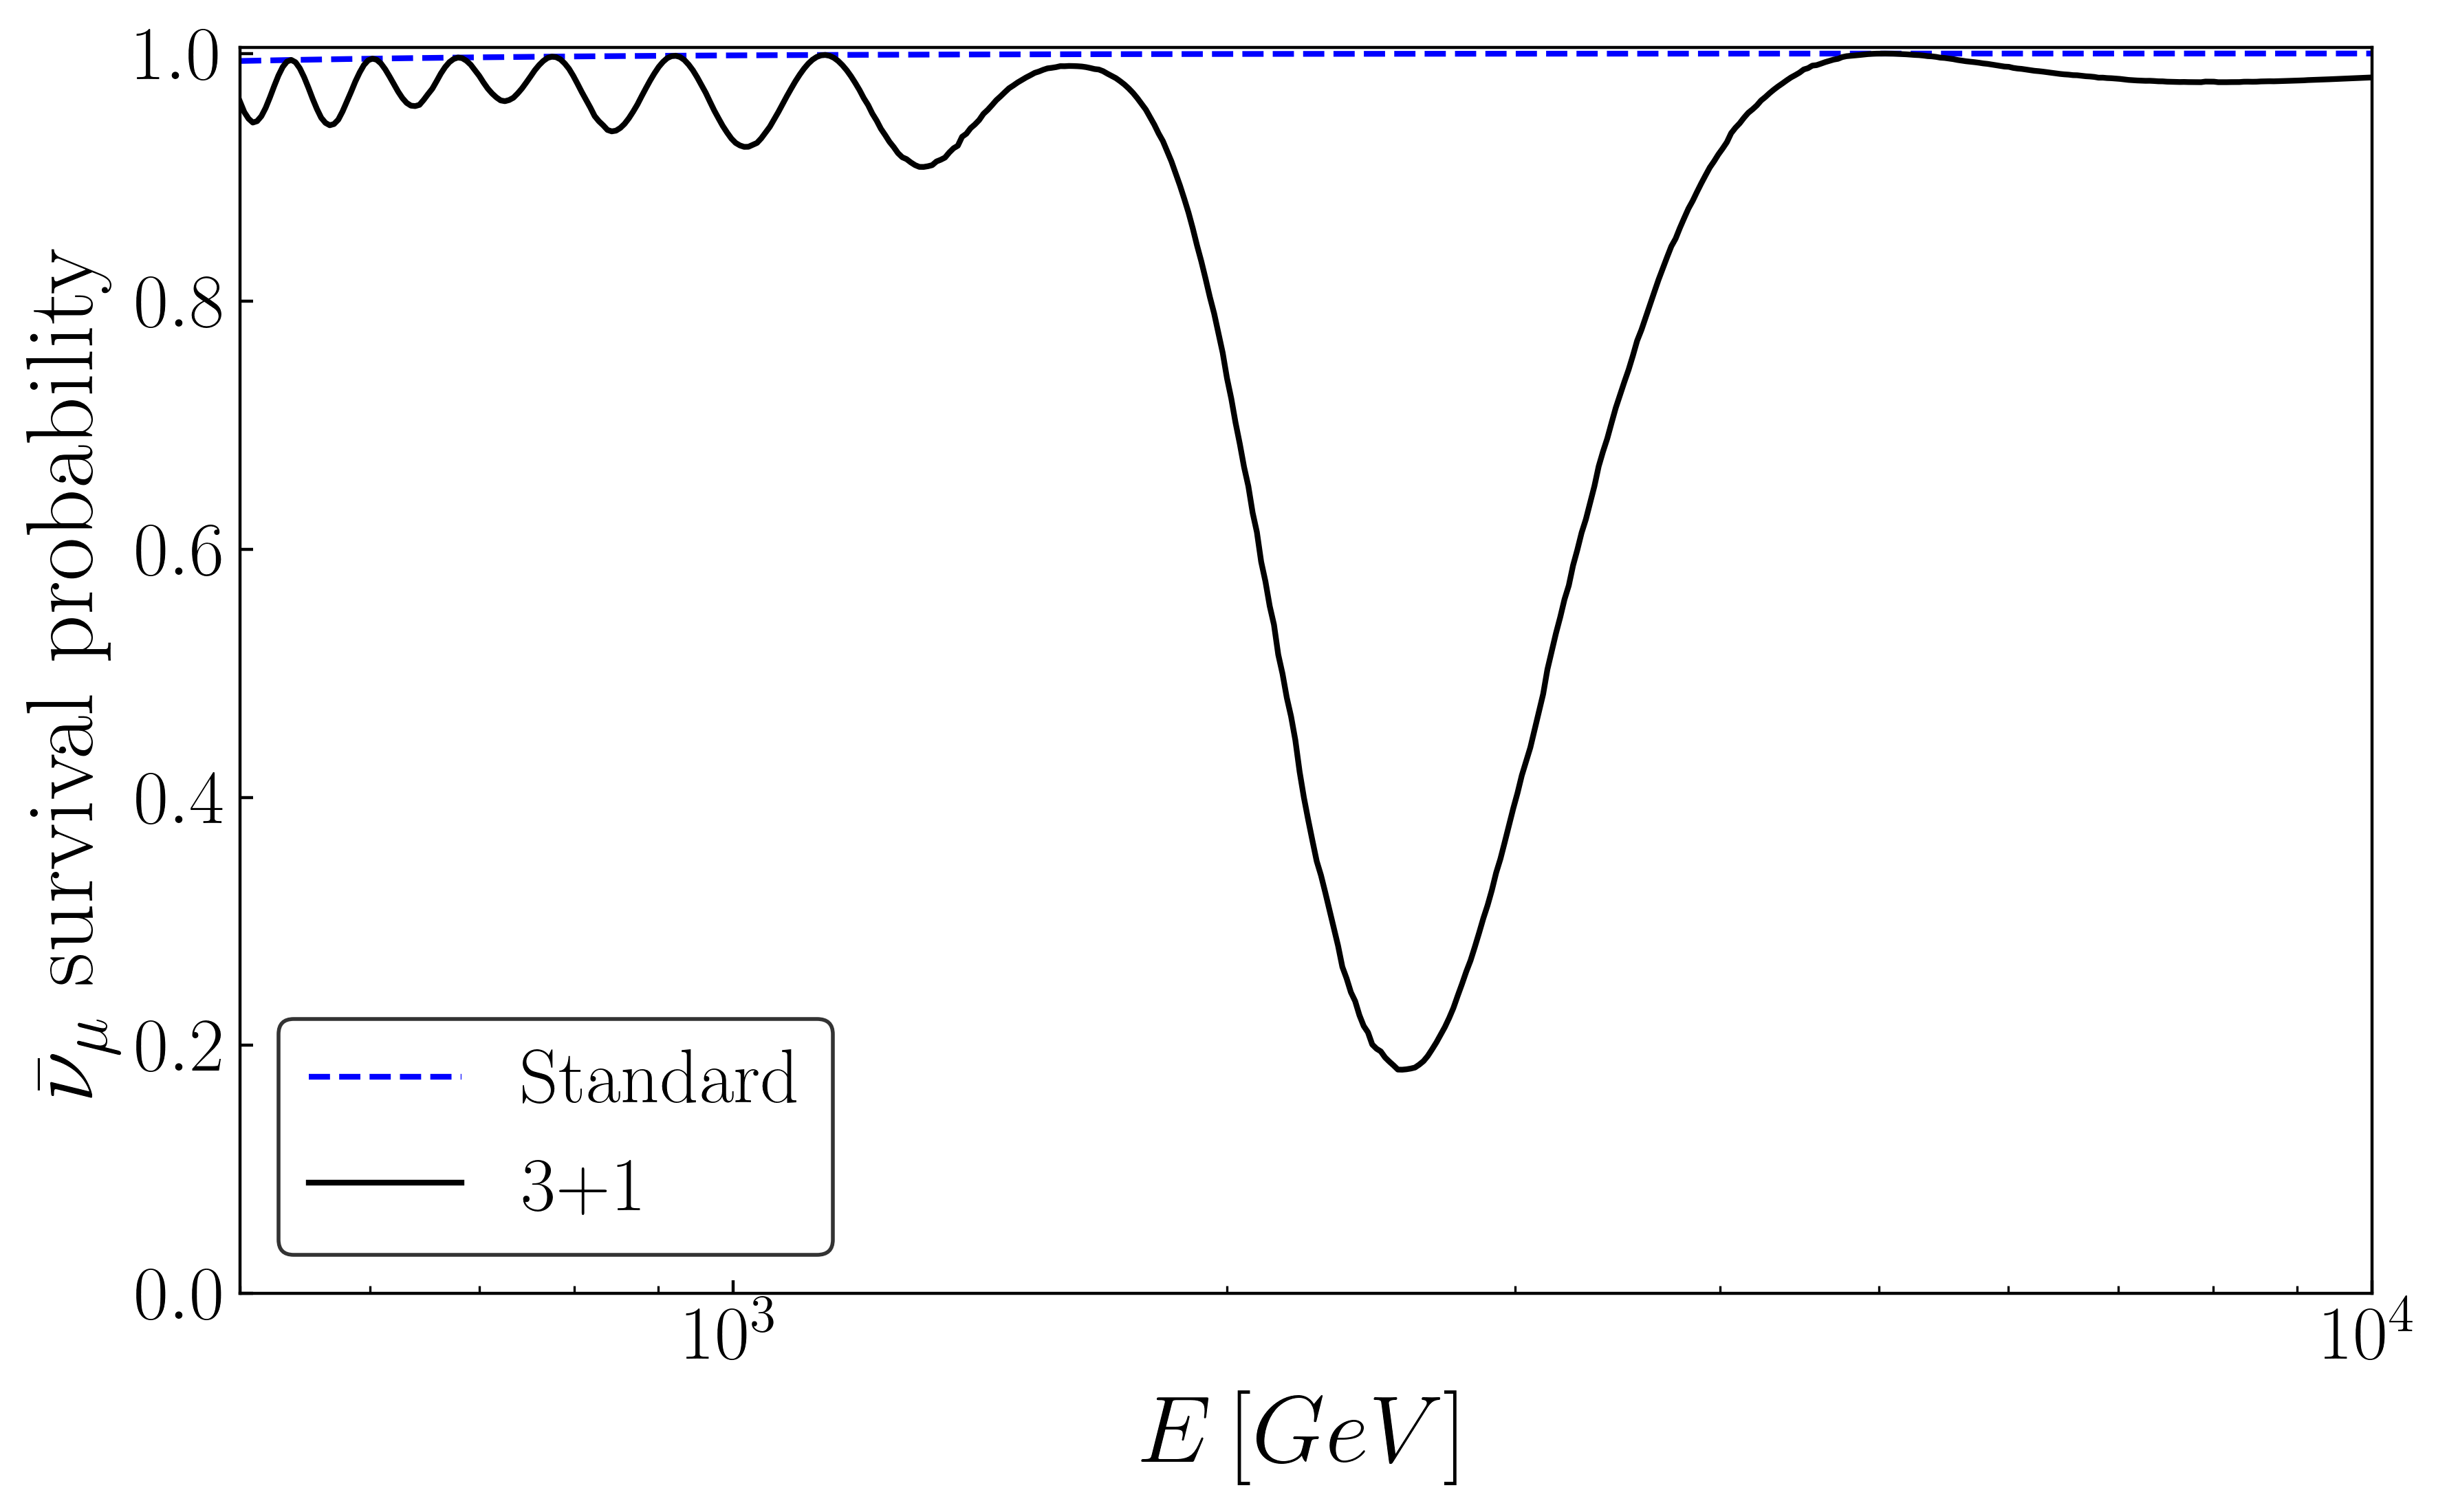

In [8]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.plot(IC_range, Pam_3gen[:,1,:].reshape(-1), color='b', ls='dashed', label='Standard')
ax.plot(IC_range, Pam_4gen[:,1,:].reshape(-1), color='k', ls='solid', label='3+1')
ax.set_xlabel(r'$E\,[GeV]$', fontsize=20)
ax.set_ylabel(r'$\bar{\nu}_\mu$ survival probability', fontsize=25)
ax.set_xscale('log')
ax.set_ylim(0,1.005)
ax.set_xlim(500,10000)
leg = ax.legend(fontsize=20)
leg.get_frame().set_edgecolor('k')

ax.tick_params(axis='both', direction='in', which='both')
ax.tick_params(labelsize=25)
savethesis(fig, 'sterile_resonance')

In [41]:
param_list = list_of_params(params, [0.5, 1, 3], [0.04])
Pam_dm = P_over_E_parameter('m', param_list, IC_range, ndim=4, anti=True)
param_list = list_of_params(params, [1], [0.02, 0.04, 0.08])
Pam_th = P_over_E_parameter('m', param_list, IC_range, ndim=4, anti=True)

In [28]:
np.arcsin(np.sqrt(0.02))/2

0.07094852730208195

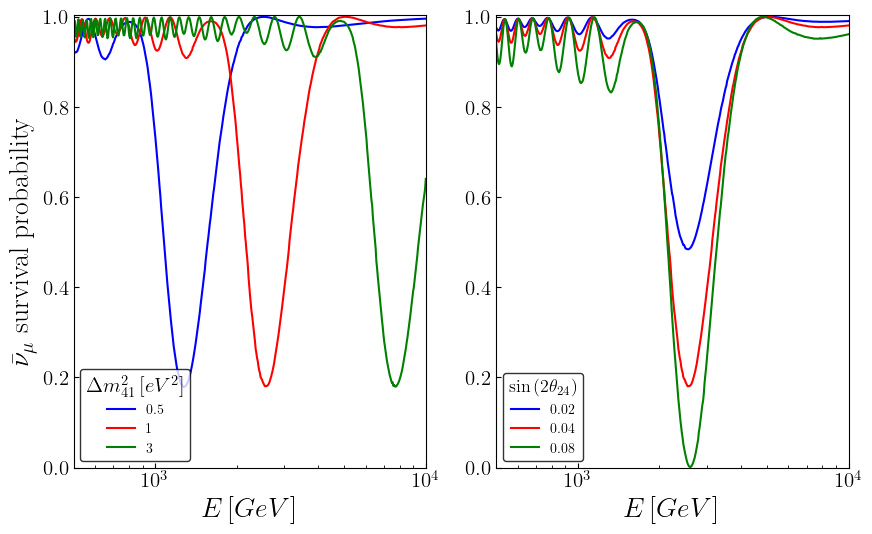

In [57]:
fig, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].plot(IC_range, Pam_dm[0,1,:].reshape(-1), color='b', ls='solid', label=r'0.5')
ax[0].plot(IC_range, Pam_dm[1,1,:].reshape(-1), color='r', ls='solid', label=r'1')
ax[0].plot(IC_range, Pam_dm[2,1,:].reshape(-1), color='g', ls='solid', label=r'3')
ax[0].set_xlabel(r'$E\, [GeV]$', fontsize=20)
ax[0].set_ylabel(r'$\bar{\nu}_\mu$ survival probability', fontsize=20)
ax[0].set_xscale('log')
ax[0].set_ylim(0,1.005)
ax[0].set_xlim(500,10000)
leg = ax[0].legend(fontsize = 10, title_fontsize=15, title=r'$\Delta m^2_{41}\, [eV^2]$', loc='lower left')
leg.get_frame().set_edgecolor('k')

ax[0].tick_params(axis='both', direction='in', which='both')
ax[0].tick_params(labelsize=15)

ax[1].plot(IC_range, Pam_th[0,1,:].reshape(-1), color='b', ls='solid', label=r'0.02')
ax[1].plot(IC_range, Pam_th[1,1,:].reshape(-1), color='r', ls='solid', label=r'0.04')
ax[1].plot(IC_range, Pam_th[2,1,:].reshape(-1), color='g', ls='solid', label=r'0.08')
ax[1].set_xlabel(r'$E\, [GeV]$', fontsize=20)
ax[1].set_xscale('log')
ax[1].set_ylim(0,1.005)
ax[1].set_xlim(500,10000)
leg = ax[1].legend(fontsize=10, title=r'$\sin{(2\theta_{24})}$', title_fontsize=13)
leg.get_frame().set_edgecolor('k')

ax[1].tick_params(axis='both', direction='in', which='both')
ax[1].tick_params(labelsize=15)
savethesis(fig, 'resonance_shift')

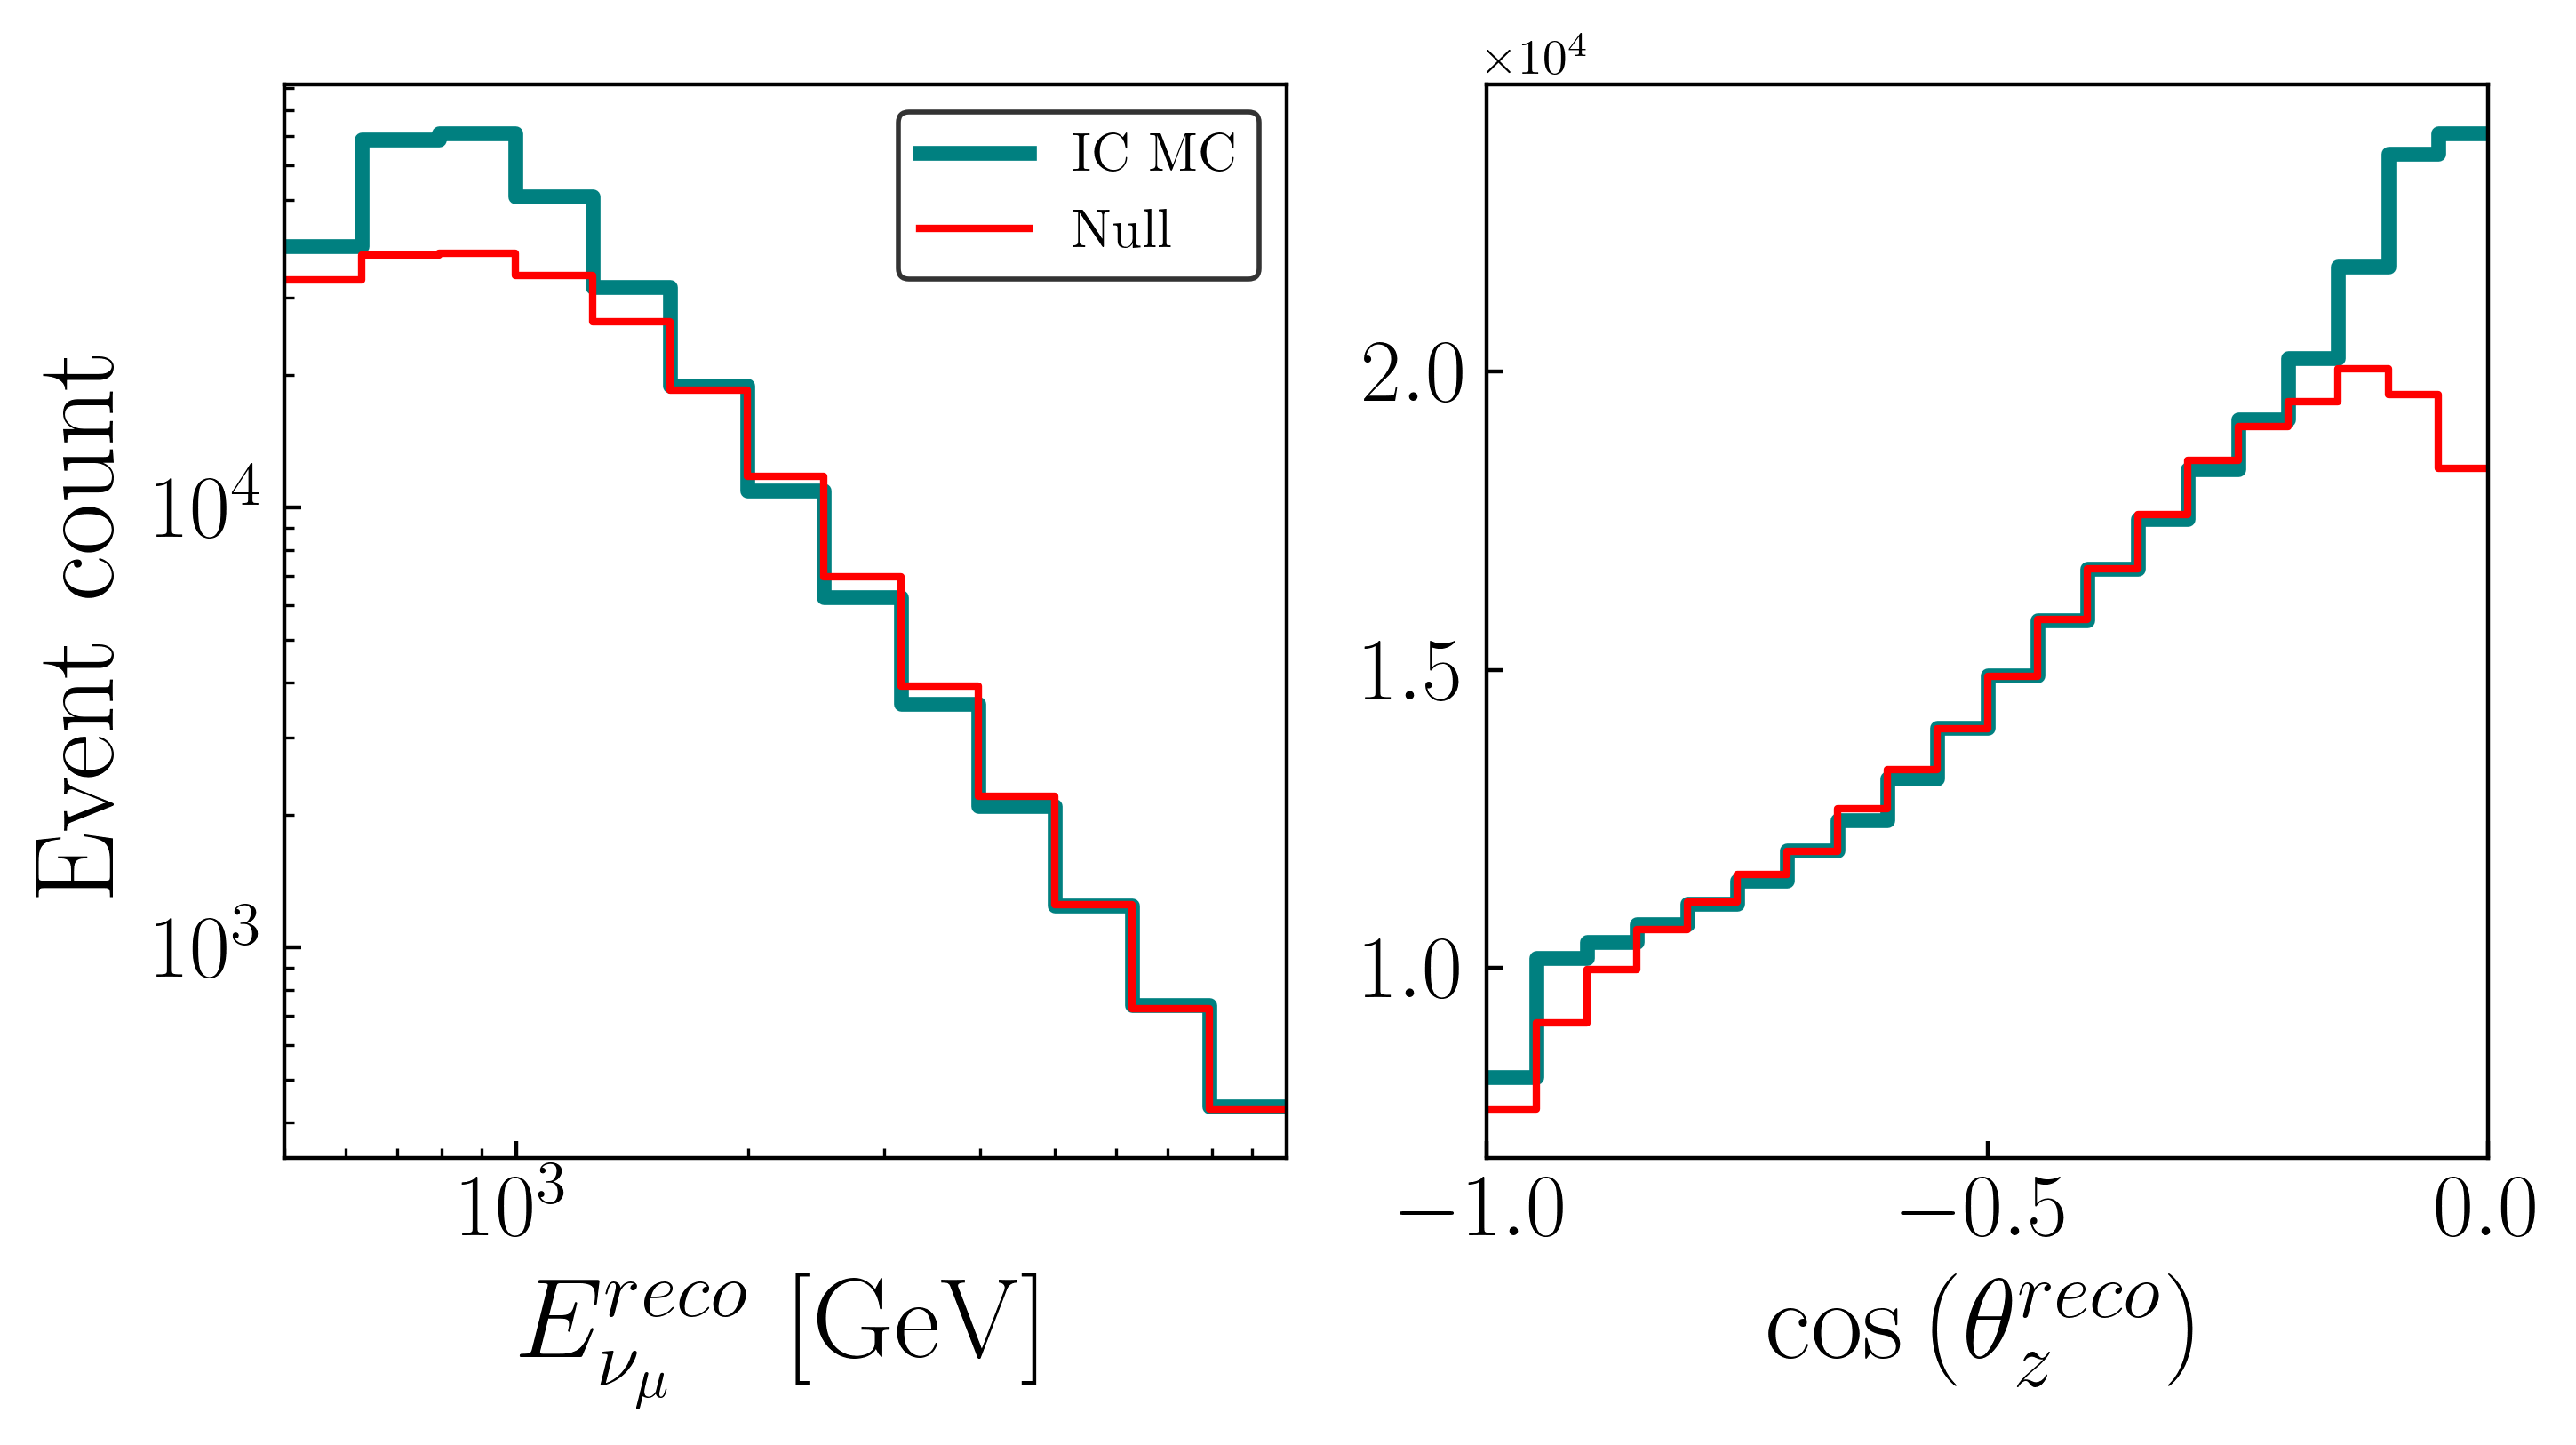

In [39]:
H0_events = pickle.load(open(f'./pre_computed/H0_IC_N17.p','rb'))#[0,:,:]

IC_per_z = np.sum(IC_observed, axis=0)
IC_per_E = np.sum(IC_observed, axis=1)

IC_rate_z = IC_per_z /np.sum(H0_events, axis= 0)
IC_rate_E = IC_per_E /np.sum(H0_events, axis= 1)

H0_per_z_hist = to_hist(np.sum(H0_events, axis= 0))*1.5
H0_per_E_hist = to_hist(np.sum(H0_events, axis= 1))*1.1

MC_per_z_hist = to_hist(MC_per_z_full[zFrom:zTo])
MC_per_E_hist = to_hist(MC_per_E_full[EFrom:ETo])


label_size = 23
tick_size = 18
legend_size=11
fig, ax = plt.subplots(1,2, squeeze=True, figsize=(8,4))
ax = ax.flatten()

ax[0].step(Ereco, MC_per_E_hist, label=r'$\mathrm{IC\,\, MC}$',lw=3, where='post', color='teal')
ax[0].step(Ereco, H0_per_E_hist, label=r'$\mathrm{Null}$',   lw=1.5, where='post', color='red')

ax[1].step(zreco, MC_per_z_hist, label='IC MC',lw=3, where='post', color='teal')
ax[1].step(zreco, H0_per_z_hist, label='Null',   lw=1.5, where='post', color='red')


ax[0].set_xscale('log')
ax[0].set_yscale('log')
#ax[1].set_yscale('log')

ax[0].set_xlim((Ereco.min(),Ereco.max()))
ax[1].set_xlim((zreco.min(),zreco.max()))
ax[0].set_ylabel(r'$\mathrm{Event\,\, count}$', fontsize=label_size)
#ax[1].set_ylabel(r'$\mathrm{Event\,\, count}$', fontsize=label_size)
ax[0].set_xlabel(r'$E^{reco}_{\nu_\mu}$ $[\si{\GeV}]$', fontsize=label_size)
ax[1].set_xlabel(r'$\cos{(\theta^{reco}_z)}$', fontsize=label_size)
ax[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
#ax[0].grid(True,which='both', axis='both', alpha=0.3)
#ax[1].grid(True,which='both', axis='both', alpha=0.3)

ax[0].tick_params(axis='both', direction='in', which='both', labelsize=tick_size)
ax[1].tick_params(axis='both', direction='in', which='both', labelsize=tick_size)

leg= ax[0].legend(fontsize=legend_size)
leg.get_frame().set_edgecolor('k')

plt.subplots_adjust(hspace=0.3)
savethesis(fig,'IC_MC_norm')

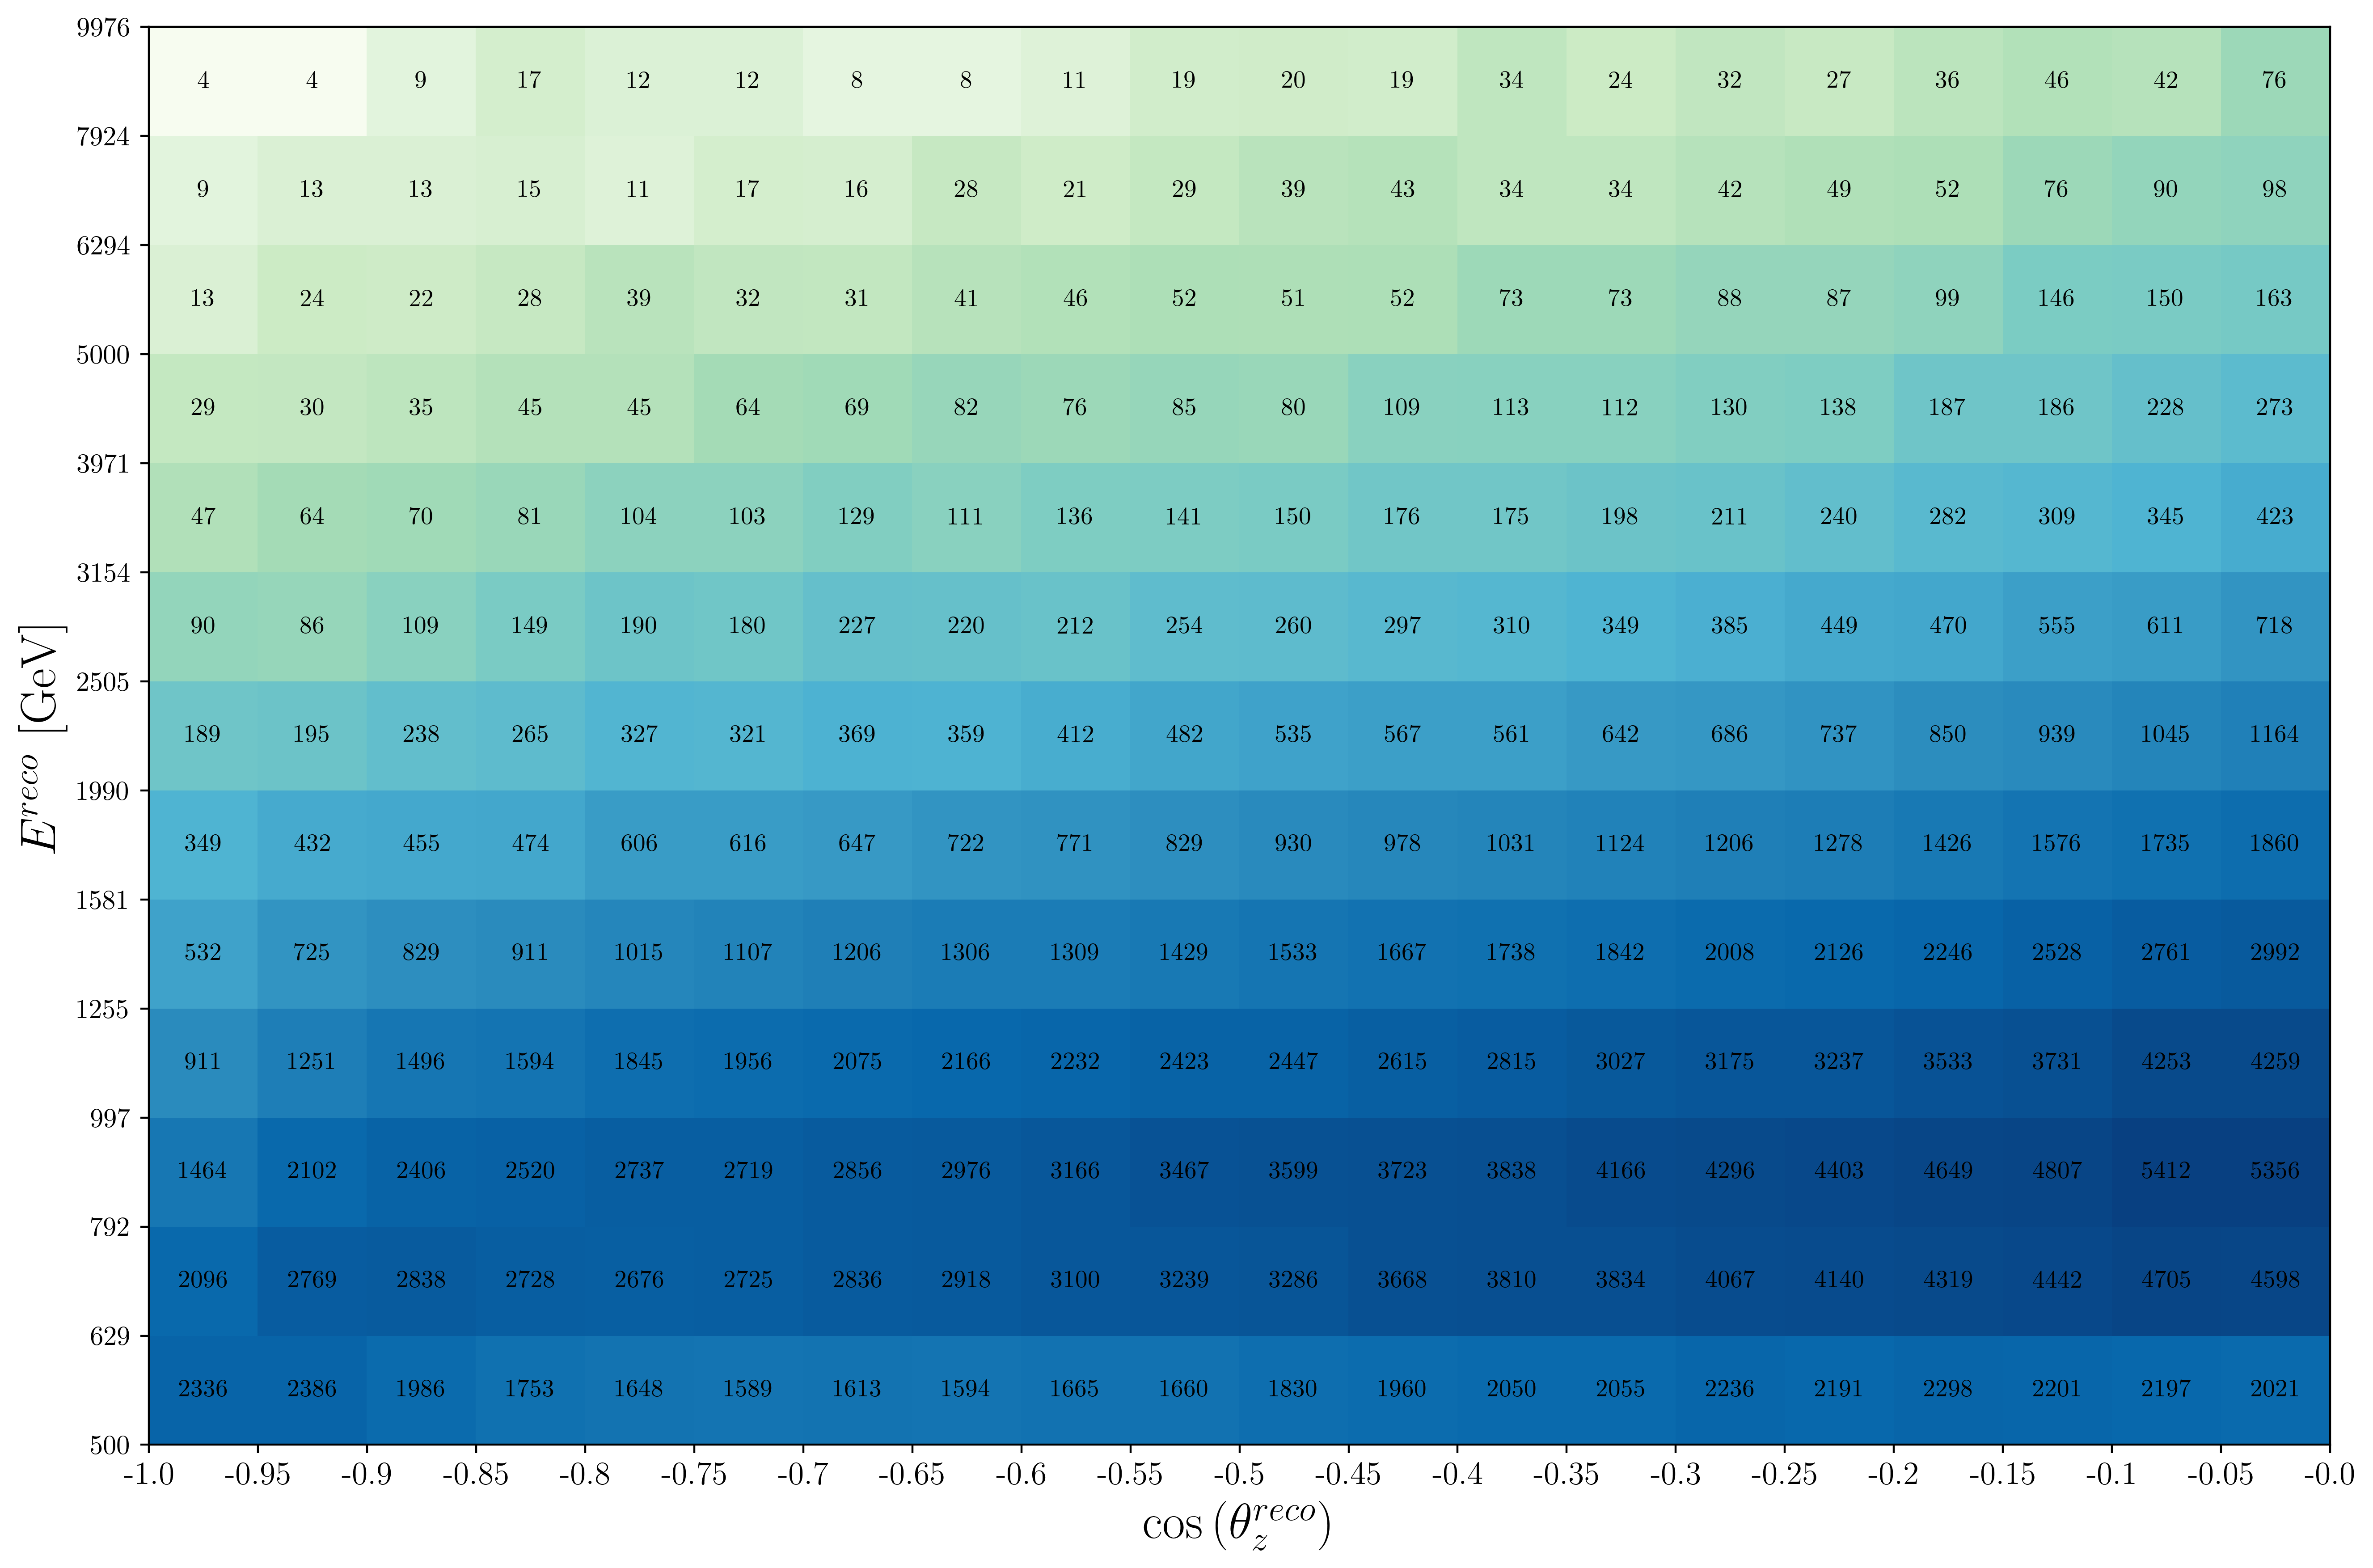

In [4]:
fig, ax = plt.subplots()

fig.set_size_inches(18.5, 10.5)
im = ax.imshow(np.log10(IC_observed_full),cmap="GnBu",origin='lower', extent= (0, n_zbins, 0, n_Ebins))

for i in range(13):
    for j in range(20):
        text = ax.text(j+0.5, i+0.5, np.round(np.asarray(IC_observed_full)[i,j],1),ha="center", va="center", color="black")

ax.set_xlabel(r'$\cos{(\theta_z^{reco})}$', fontsize=20)
ax.set_ylabel(r'$E^{reco}\,\, [\si{GeV}]$', fontsize=20)
ax.set_xticks(np.arange(n_zbins+1))
_=ax.set_xticklabels(np.round(np.linspace(-1.0,-0.0,n_zbins+1),2), fontsize = 13)
ax.set_yticks(np.arange(n_Ebins+1))
E_ticks = 500*10**np.linspace(0.0,1.3,n_Ebins+1)
ax.set_yticklabels(E_ticks.astype(int), fontsize=11)
savethesis(fig, 'IC_data')

In [3]:
def normalize_bin_by_bin(simulated_events, MC = True, MC_old=False, correct_flux=False):
    if MC_old:
        IC_events = IC_MC_2017
    elif MC:
        IC_events = IC_MC

    if correct_flux:
        simulated_events = flux_E_factors*simulated_events

    normalization = IC_events/simulated_events

    return np.array(normalization)

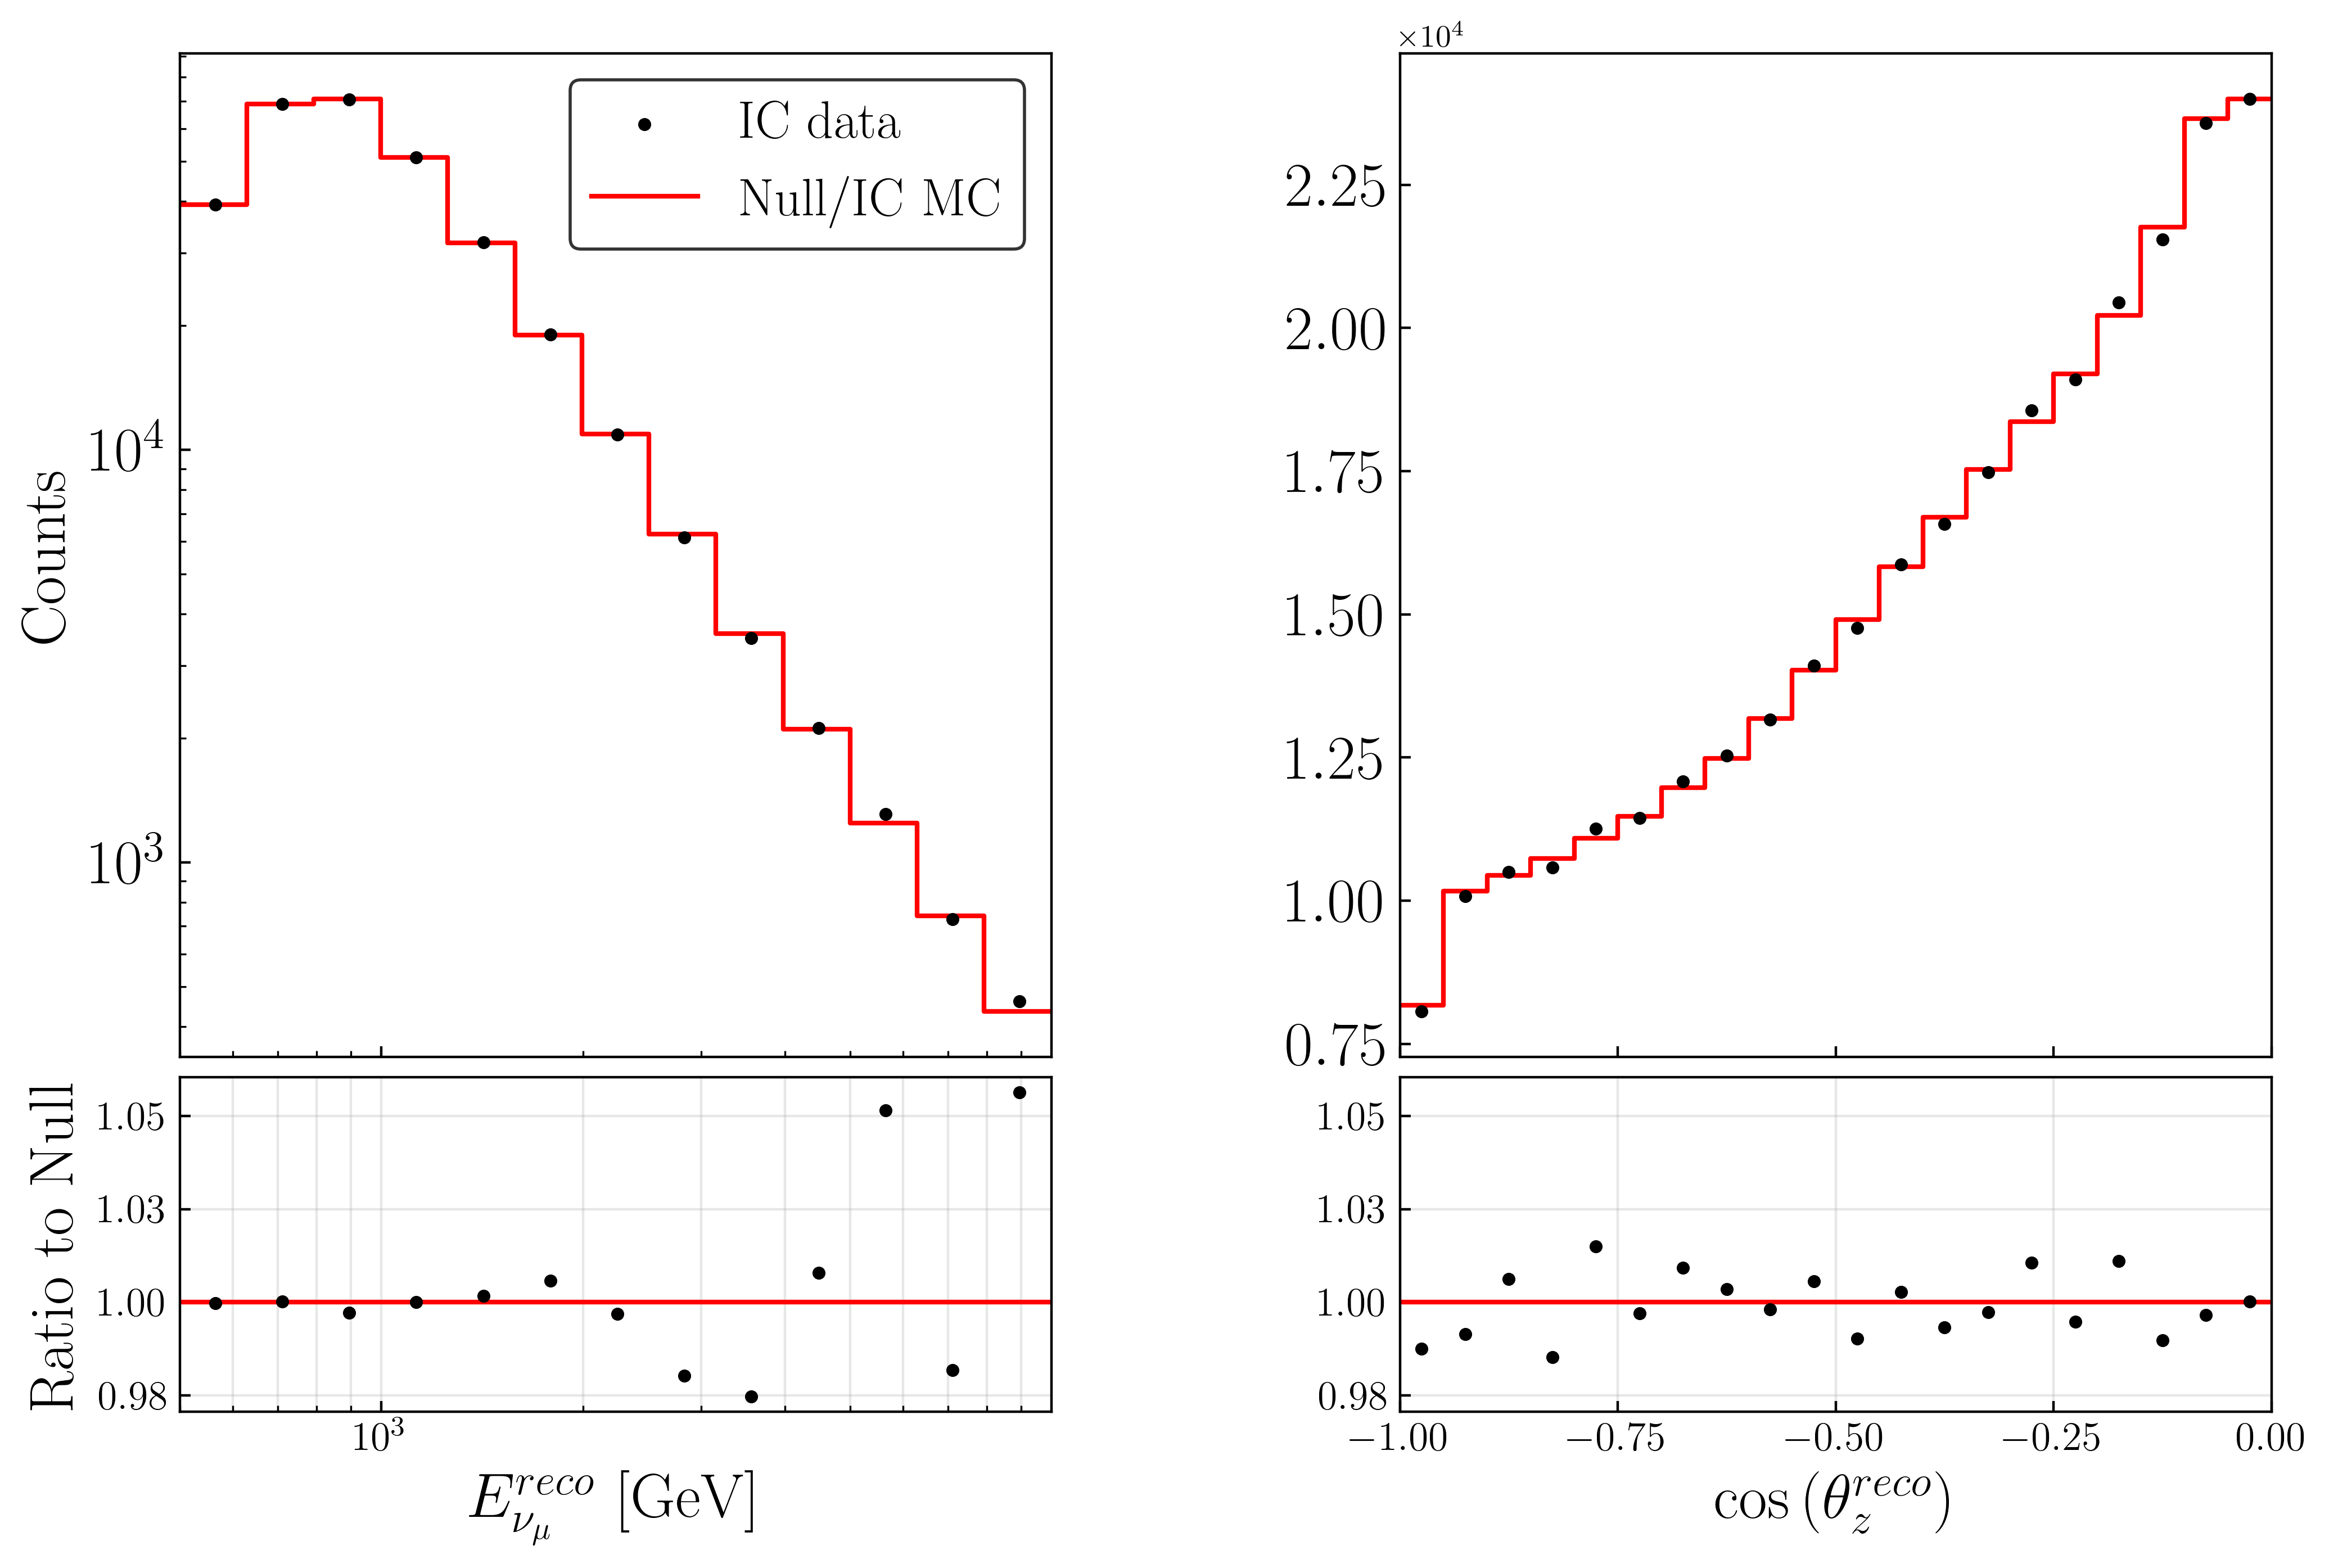

In [32]:
H0_events = pickle.load(open(f'./pre_computed/H0_IC_N17.p','rb'))#[0,:,:]
IC_per_z = np.sum(IC_observed, axis=0)
IC_per_E = np.sum(IC_observed, axis=1)

norm_factors = normalize_bin_by_bin(H0_events)

IC_rate_z = IC_per_z /np.sum(norm_factors*H0_events, axis= 0)
IC_rate_E = IC_per_E /np.sum(norm_factors*H0_events, axis= 1)

H0_per_z_hist = to_hist(np.sum(norm_factors*H0_events, axis= 0))
H0_per_E_hist = to_hist(np.sum(norm_factors*H0_events, axis= 1))


H0_rate_z_hist = to_hist(np.sum(norm_factors*H0_events, axis= 0) / np.sum(norm_factors*H0_events, axis= 0))
H0_rate_E_hist = to_hist(np.sum(norm_factors*H0_events, axis= 1) / np.sum(norm_factors*H0_events, axis= 1))

fig, ax = plt.subplots(2,2, sharex='col', squeeze=True,gridspec_kw={'width_ratios': [3, 3], 'height_ratios':[3,1]}, figsize=(12,8))
ax = ax.flatten()

label_size = 20
tick_size =  20
legend_size= 17

ax[0].scatter(Ereco_midpoints, IC_per_E, label='IC data', s=10, color='black', zorder=10)
#ax[0].step(Ereco, H1_per_E_hist, label='Sterile',lw=3, where='post', color='blue')
ax[0].step(Ereco, H0_per_E_hist, label='Null/IC MC',   lw=1.5, where='post', color='red')

ax[1].scatter(zreco_midpoints, IC_per_z, label='IC data', s=10, color='black',zorder=10)
#ax[1].step(zreco, H1_per_z_hist, label='Sterile',lw=3, where='post', color='blue')
ax[1].step(zreco, H0_per_z_hist, label='Null',   lw=1.5, where='post', color='red')

ax[2].scatter(Ereco_midpoints, IC_rate_E, label='IC data',  s=10, color='black',zorder=10)
#ax[2].step(Ereco, H1_rate_E_hist, label='Sterile',lw=3, where='post', color='blue')
ax[2].step(Ereco, H0_rate_E_hist, label='Null',   lw=1.5, where='post', color='red')

ax[3].scatter(zreco_midpoints, IC_rate_z, label='IC data',  s=10, color='black',zorder=10)
#ax[3].step(zreco, H1_rate_z_hist, label='Sterile',lw=3, where='post', color='blue')
ax[3].step(zreco, H0_rate_z_hist, label='Null',   lw=1.5, where='post', color='red')


ax[0].set_xlim((Ereco.min(),Ereco.max()))
ax[0].set_ylabel('Counts', fontsize=label_size)
ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[2].set_xscale('log')
ax[2].set_xlabel(r'$E_{\nu_\mu}^{reco}$ [GeV]', fontsize=label_size)
ax[2].set_ylabel('Ratio to Null', fontsize=label_size)
ax[2].grid(True,which='both', axis='both', alpha=0.3)

ax[3].set_xlim((zreco.min(),zreco.max()))
ax[3].set_ylim(ax[2].get_ylim())
ax[3].grid(True,which='both', axis='both', alpha=0.3)
ax[3].set_xlabel(r'$\cos{(\theta^{reco}_z)}$', fontsize=label_size)

plt.subplots_adjust(hspace=0.03, wspace=0.4)

ax[0].tick_params(axis='both', direction='in', which='both', labelsize=tick_size)
ax[1].tick_params(axis='both', direction='in', which='both', labelsize=tick_size)
ax[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))

ax[2].tick_params(axis='both', direction='in', which='both', labelsize=tick_size-7)
ax[3].tick_params(axis='both', direction='in', which='both', labelsize=tick_size-7)
from matplotlib.ticker import FormatStrFormatter
ax[2].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax[3].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

leg= ax[0].legend(fontsize=legend_size)
leg.get_frame().set_edgecolor('k')
savethesis(fig, 'IC_rates')

In [7]:
wrap_param('m', [1e2,1e3], -1, 4, True, params, False).shape

(4, 4, 2)

In [10]:
from src.plotter import flux_oscillogram, wrap_param
E_range = np.logspace(2,5,2)
z_range= np.linspace(-1,0,1)
dm_range = np.logspace(-1,2,1)
s24_range = np.logspace(-2,0,4)
params = list_of_params(ic_params, dm_range,s24_range)
res = flux_oscillogram(E_range, z_range, params, nsi=False)

IndexError: too many indices for array: array is 0-dimensional, but 3 were indexed

In [4]:
from src.plotter import wrap

In [6]:
wrap('m', [1e2], -1, 4, True,params[0],False)

{'theta_12': 0.5837630475986898, 'theta_13': 0.15494769630192953, 'theta_23': 0.7695841386786632, 'theta_34': 0, 'theta_24': 0.0500837105807799, 'theta_14': 0, 'delta_ij': 3.4033920413889422, 'dm_21': 7.53e-05, 'dm_31': 0.0025153, 'dm_41': 0.1}


array([[4.220e-04],
       [8.400e-01],
       [1.423e-01],
       [1.738e-02]])